# 01 - Prepare & chunk corpus

Description du notebook :
- charge les positions de thèses depuis un fichier TSV structuré,
- effectue une analyse exploratoire du corpus,
- applique une stratégie de découpage (chunking) custom,
- prépare les données pour une indexation vectorielle future (composant du Retriever dans le RAG)


ℹ️ Tous les paramètres (modèles, chemins, chunking, etc.) sont externalisés dans [`config.yml`](../config.yml),
ce qui permet de relancer facilement le notebook avec d'autres réglages.

In [1]:
# Imports globaux

import os
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from transformers import AutoTokenizer
from langchain.text_splitter import RecursiveCharacterTextSplitter
from utils.io_utils import (get_absolute_path,
                            read_yaml)

## Chargement de la configuration

In [2]:
config = read_yaml("../config.yml")

data_path = get_absolute_path(config['data']['source'])
CHUNK_SIZE = config['chunking']['chunk_size']
# on calcule le chunk overlap comme 10% de la taille du chunk. Ce qui permet de définir dynamiquement le chunk overlap pour éviter les erreurs de taille.
CHUNK_OVERLAP =  int(CHUNK_SIZE / 10)
TEXT_COL = config['data']['text_column']

## Chargement des données

e dataset comprend les 3057 thèses disponibles sur le site [https://theses.chartes.psl.eu/](https://theses.chartes.psl.eu/) via un scrapper qui utilise l'API DoTS.

Modèle de données

---

- `text` : the text of the document that will be vectorized indexed. Each text row corresponding to a signifiant section of the document (e.g. introduction, chapters, conclusion, appendices, etc.) and corresponding to a first "semantic chunking" of the document.

and the metadata columns (important to retrieve and identify the document later):
- `unique_id` : the unique identifier of the document (e.g. "ENCPOS_2023_01_5"; "01": first thesis of the collection year 2023, "5": section 5 of the thesis)
- `file_id` : the identifier of the document (util for research in Web)
- `author` : the author of the document (positions de thèses)
- `section` : the section title of the document (e.g. introduction, chapters, conclusion, appendices, etc.)
- `title` : the title of the document
- `position_name` : the name of the position
- `year` : the year of the document
- `text_token_length` : the length of the text in tokens

In [3]:
df = pd.read_csv(data_path, sep="\t", encoding="utf-8")
# First ensure the columns are in the right format: Check if the columns exist and convert them to the appropriate types, check non null values
df['year'] = pd.to_numeric(df['year'], errors='coerce').fillna(0).astype(int)
for col in ['file_id', 'unique_id', 'author', 'section', 'text', 'position_name']:
    df[col] = df[col].astype(str)

df.head()

,unique_id,file_id,year,author,position_name,section,text,text_token_length
0,ENCPOS_1849_01_1,ENCPOS_1849_01,1849,Léon de Bastard d'Estang,Recherches sur l’origine et la nature des insu...,I.,L’ insurrection de 1106 contre l’abbé Artaud a...,21
1,ENCPOS_1849_01_2,ENCPOS_1849_01,1849,Léon de Bastard d'Estang,Recherches sur l’origine et la nature des insu...,II.,La conspiration des bourgeois sous l’abbé Albé...,20
2,ENCPOS_1849_01_3,ENCPOS_1849_01,1849,Léon de Bastard d'Estang,Recherches sur l’origine et la nature des insu...,III.,"L’ insurrection communale proprement dite, ver...",13
3,ENCPOS_1849_01_4,ENCPOS_1849_01,1849,Léon de Bastard d'Estang,Recherches sur l’origine et la nature des insu...,IV.,L’origine de cette insurrection remonte à la r...,18
4,ENCPOS_1849_01_5,ENCPOS_1849_01,1849,Léon de Bastard d'Estang,Recherches sur l’origine et la nature des insu...,V.,"La commune, qui en est la suite, n’a qu’une ex...",25


## Analyse statistique

In [4]:
print("--- Statistiques initiales ---")
print("Nombre total de sections :", len(df))
max_text_token_length = df['text_token_length'].max()
min_text_token_length = df['text_token_length'].min()
mean_text_token_length = df['text_token_length'].mean()
print("Longueur maximale (tokens) :", int(max_text_token_length))
print("Longueur minimale (tokens) :", int(min_text_token_length))
print("Longueur moyenne (tokens) :", int(mean_text_token_length))

--- Statistiques initiales ---
Nombre total de sections : 34049
Longueur maximale (tokens) : 2292
Longueur minimale (tokens) : 1
Longueur moyenne (tokens) : 200


On observe que la plupart des sections ont une longueur raisonnable, mais il y a aussi des sections très courtes (< 3 tokens). La question de savoir s'il faut les conservés ou non. Observons quelques exemples de sections très courtes.

In [5]:
examples = df[df['text_token_length'] < 6].drop_duplicates().head(10)
print("\nExemples de sections très courtes :")
for i, row in examples.iterrows():
    print(f"{i+1}. '{row[TEXT_COL]}' (tokens: {row['text_token_length']})")


Exemples de sections très courtes :
238. 'Documents et figures.' (tokens: 3)
248. 'Pièces justificatives.' (tokens: 2)
258. 'Vie de Gautier de Coincy.' (tokens: 5)
350. 'Pièces justificatives.' (tokens: 2)
659. 'Sa famille. – 1258-1280.' (tokens: 4)
938. 'Analyse du Jouvencel par chapitres.' (tokens: 5)
995. 'Vie de Robert IV.' (tokens: 4)
1212. 'Réforme du chapitre de Picquigny.' (tokens: 5)
1376. 'Des executores. – Leurs diverses désignations.' (tokens: 5)
1717. 'Analyse de soixante-dix documents.' (tokens: 5)


Certaines sections < 3 tokens pourraient être des titres, des en-têtes ou des notes orphelines. Ces sections risquent d'introduire du bruit plus tard dans le modèle de recherche sémantique. En revanche d'autres sections courtes (> 3 tokens) commence à contenir de l'information utile comme des entités nommées (personnes, dates, lieux, etc.) ou des concepts clés.
Nous proposons donc de filtrer les sections trop courtes (< 4 tokens) et plus tard dans notre stratégie de chunking d'ajouter un préfixe avec le titre de la section pour donner du contexte aux chunks.

In [6]:
df = df[df['text_token_length'] >= 4].reset_index(drop=True)
print("\nSections conservées après filtre (>=4 tokens) :", len(df))


Sections conservées après filtre (>=4 tokens) : 33989


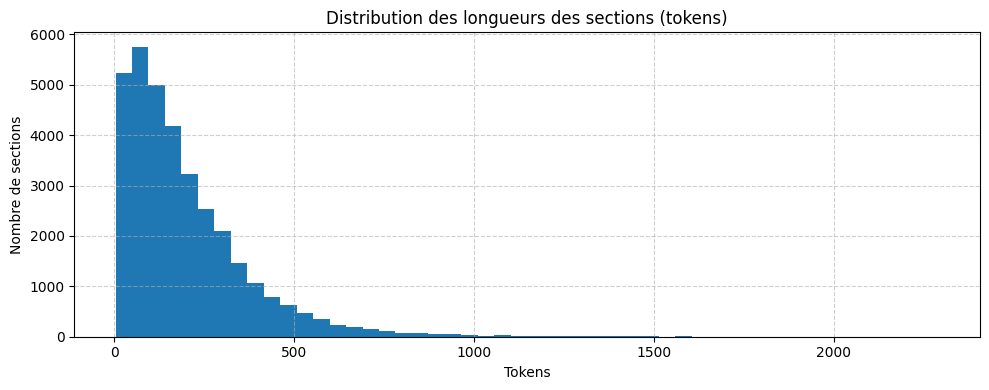

In [7]:
## Histogramme de la longueur des textes
plt.figure(figsize=(10, 4))
df['text_token_length'].hist(bins=50)
plt.title('Distribution des longueurs des sections (tokens)')
plt.xlabel('Tokens')
plt.ylabel('Nombre de sections')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

L'autre problème c'est qu'on voit ici que certaines sections sont très longues (plus de 1000 tokens). Ces sections risquent de dépasser la limite d'entrée de certains modèles d'embedding  que nous souhaitons appliquer par la suite regardons de plus près.

In [8]:
from sentence_transformers import SentenceTransformer

camembert_base_max_length = SentenceTransformer('Lajavaness/sentence-camembert-base').max_seq_length
camembert_large_max_length = SentenceTransformer('Lajavaness/sentence-camembert-large').max_seq_length
multilingual_max_length = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v1').max_seq_length


print(f"CamemBERT base max length: {camembert_base_max_length}")
print(f"CamemBERT large max length: {camembert_large_max_length}")
print(f"Multilingual base max length: {multilingual_max_length}")

CamemBERT base max length: 128
CamemBERT large max length: 514
Multilingual base max length: 128


Il faut donc appliquer un découpage (chunking) pour créer des sous-textes de taille fixe pour les sequences les plus longues.

## Chunking method

Il existe de nombreuse manière de découper un texte en chunks (characters, sentences, paragraphs, etc.): Il n'y a pas de méthode universelle, mais il faut choisir la méthode la plus adaptée à son cas d'usage.

Deux paramètres sont importants à prendre en compte :
- `CHUNK_SIZE` : la taille maximale des chunks en tokens (ex: 512 tokens pour CamemBERT).
- `CHUNK_OVERLAP` : le nombre de tokens qui se chevauchent entre les chunks (ex: 10% de la taille du chunk, soit 51 tokens pour un chunk de 512 tokens).

Ici on utilise une stratégie de double chunking :

- Le premier découpage est déjà effectué via le scraping par section (découpage sémantique) Cf.supra.
- Le second est un découpage par tokens, car les modèles d'embedding ont une limite fixe d'entrée (ex: 514 tokens).
- Chaque chunk est enrichi avec le titre de la section pour donner du contexte (ex: "Introduction : le ...").

In [9]:
tokenizer = AutoTokenizer.from_pretrained("Lajavaness/sentence-camembert-large", use_fast=True)
# we using RecursiveCharacterTextSplitter from langchain to split the text into chunks, this not chunking by characters but by tokens because we explicitly use "from_huggingface_tokenizer" method (Check doc: https://python.langchain.com/docs/how_to/split_by_token/#hugging-face-tokenizer).
text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer,
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    add_start_index=True,
    strip_whitespace=True,
)

In [10]:
#Fonctions de traitement :  nettoyer le texte, compter les tokens, et appliquer le découpage.

def count_tokens(text: str) -> int:
    """Retourne le nombre de tokens avec special tokens inclus."""
    return len(tokenizer(text, add_special_tokens=True)['input_ids'])

def clean_text(text: str) -> str:
    """Nettoie le texte : supprime les espaces redondants et normalise les caractères."""
    return unicodedata.normalize("NFKC", " ".join(text.strip().split()))

def remove_special_tokens_ids(token_ids: list[int]) -> list[int]:
    """Supprime les tokens spéciaux d'une liste d'IDs."""
    special_ids = tokenizer.all_special_ids
    return [tok for tok in token_ids if tok not in special_ids]

def process_row_recursive(row: pd.Series) -> list[dict]:
    """
    Applique le découpage tokenisé sur une ligne de DataFrame :
    - Nettoie le texte et ajoute le titre en préfixe.
    - Découpe en sous-textes de taille fixe (tokens spéciaux inclus).
    - Enregistre le chunk SANS les tokens spéciaux (pour usage humain / affichage).
    """
    text = clean_text(row[TEXT_COL])
    title = f"{clean_text(row['position_name'])} : "
    len_title = count_tokens(title)

    chunks = text_splitter.split_text(text)
    results = []

    for i, chunk in enumerate(chunks):
        chunk_token_ids = tokenizer(chunk, add_special_tokens=True)["input_ids"]
        total_tokens = len_title + len(chunk_token_ids)

        # Tronque si trop long
        if total_tokens > CHUNK_SIZE:
            allowed = CHUNK_SIZE - len_title
            chunk_token_ids = chunk_token_ids[:allowed]

        # Nettoyage du chunk : on enlève les special tokens pour l’enregistrement
        chunk_token_ids_clean = remove_special_tokens_ids(chunk_token_ids)
        chunk_text = tokenizer.decode(chunk_token_ids_clean, skip_special_tokens=True)

        # Texte complet avec titre + chunk nettoyé
        full_chunk = f"{title}{chunk_text}".strip()

        results.append({
            "unique_id": row["unique_id"],
            "chunk_id": f"{row['unique_id']}_chunk_{i}",
            "file_id": row.get("file_id"),
            "author": row.get("author"),
            "position_name": clean_text(row.get("position_name")),
            "year": row.get("year"),
            "section": row.get("section"),
            "raw_chunk": chunk_text,
            "full_chunk": full_chunk,
            "full_chunk_characters_len": len(full_chunk),
            "full_chunk_token_len": count_tokens(full_chunk),  # avec tokens spéciaux inclus
        })

    return results


In [11]:
## Application du chunking et sauvegarde
# On applique le découpage à chaque ligne du corpus. Si un fichier a déjà été généré, on ne le refait pas.
out_path = f"../../data/raw/encpos_chunked_tok_{CHUNK_SIZE}_{CHUNK_OVERLAP}-test.csv"
if os.path.exists(out_path):
    print(f"⚠️ Fichier déjà généré : {out_path}. Supprimez-le pour forcer le recalcul.")
    df_chunks = pd.read_csv(out_path, sep="\t")
else:
    # traitement parallèle pour accélérer le chunking. -1 utilise tous les coeurs disponibles.
    results = Parallel(n_jobs=-1)(
        delayed(process_row_recursive)(row) for _, row in tqdm(df.iterrows(), total=len(df))
    )
    flat_chunks = [item for sublist in results for item in sublist]
    # deduplication des chunks
    df_chunks = pd.DataFrame(flat_chunks).drop_duplicates(subset=["full_chunk", "unique_id"]).reset_index(drop=True)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    df_chunks.to_csv(out_path, sep="\t", encoding="utf-8", index=False)

100%|██████████| 33989/33989 [00:52<00:00, 643.25it/s] 


## Analyse post-chunking

In [12]:
## Statistiques des chunks
print("Nombre total de chunks générés :", len(df_chunks))
max_chunk_token_length = df_chunks['full_chunk_token_len'].max()
min_chunk_token_length = df_chunks['full_chunk_token_len'].min()
mean_chunk_token_length = df_chunks['full_chunk_token_len'].mean()
print("Longueur maximale (tokens) :", int(max_chunk_token_length))
print("Longueur minimale (tokens) :", int(min_chunk_token_length))
print("Longueur moyenne (tokens) :", int(mean_chunk_token_length))

Nombre total de chunks générés : 39377
Longueur maximale (tokens) : 511
Longueur minimale (tokens) : 14
Longueur moyenne (tokens) : 265


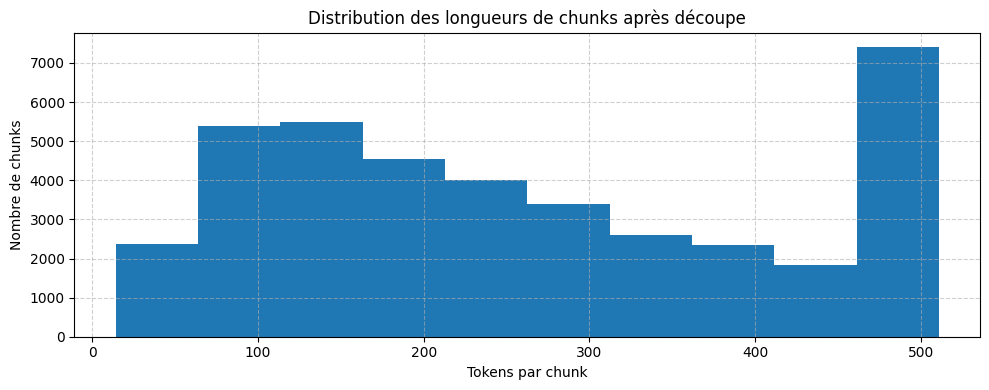

In [13]:
## Histogramme après découpe
plt.figure(figsize=(10, 4))
df_chunks['full_chunk_token_len'].hist()
plt.title('Distribution des longueurs de chunks après découpe')
plt.xlabel('Tokens par chunk')
plt.ylabel('Nombre de chunks')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

- Le volume de chunks (+ de 3000) est suffisant pour une indexation vectorielle
- La longueur moyenne des chunks est raisonnable (environ 200 tokens) pour créer des embeddings signifiants
- La longueur maximum (512 tokens) assure la compatibilité avec les modèles d'embedding.


➡️ Notebook suivant : [02-create_retrievers.ipynb](./02-create-retrievers.ipynb)